In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


# Dependencies

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import warnings 
warnings.filterwarnings("ignore")


# Explore data 

In [3]:
df=pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


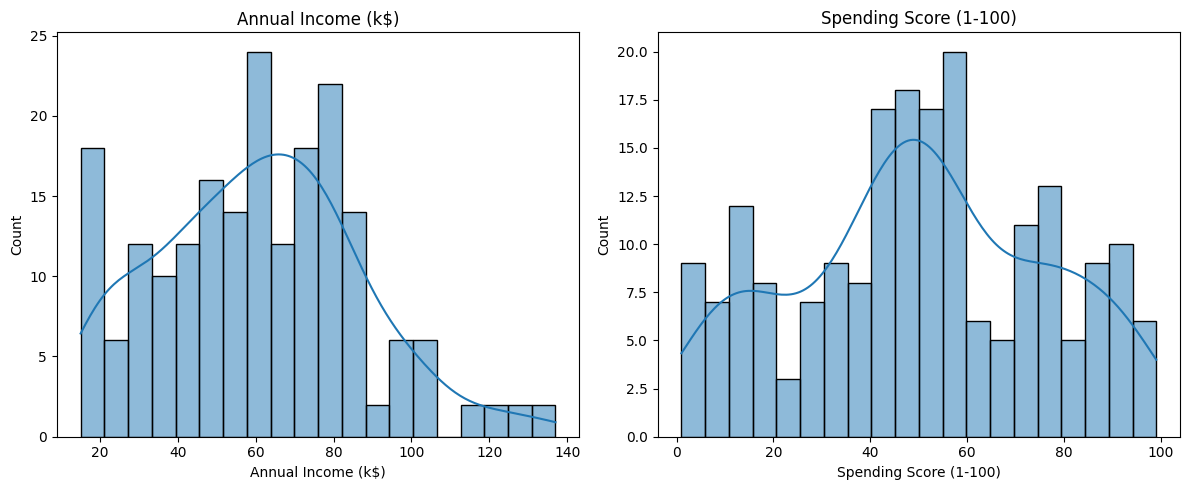

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Annual Income (k$)')
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Count')

sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Spending Score (1-100)')
axes[1].set_xlabel('Spending Score (1-100)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


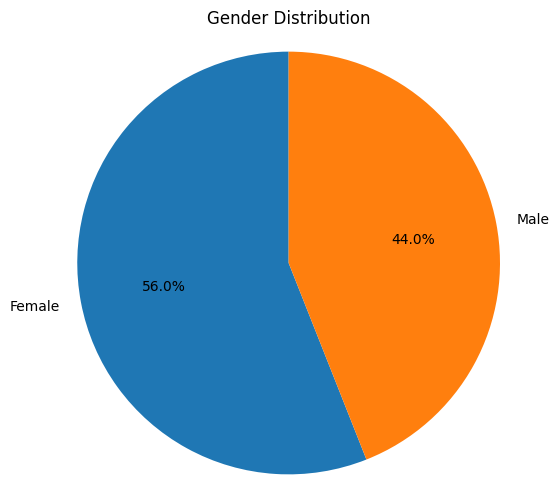

In [7]:

gender_counts = df['Gender'].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Gender Distribution')
plt.axis('equal') 
plt.show()


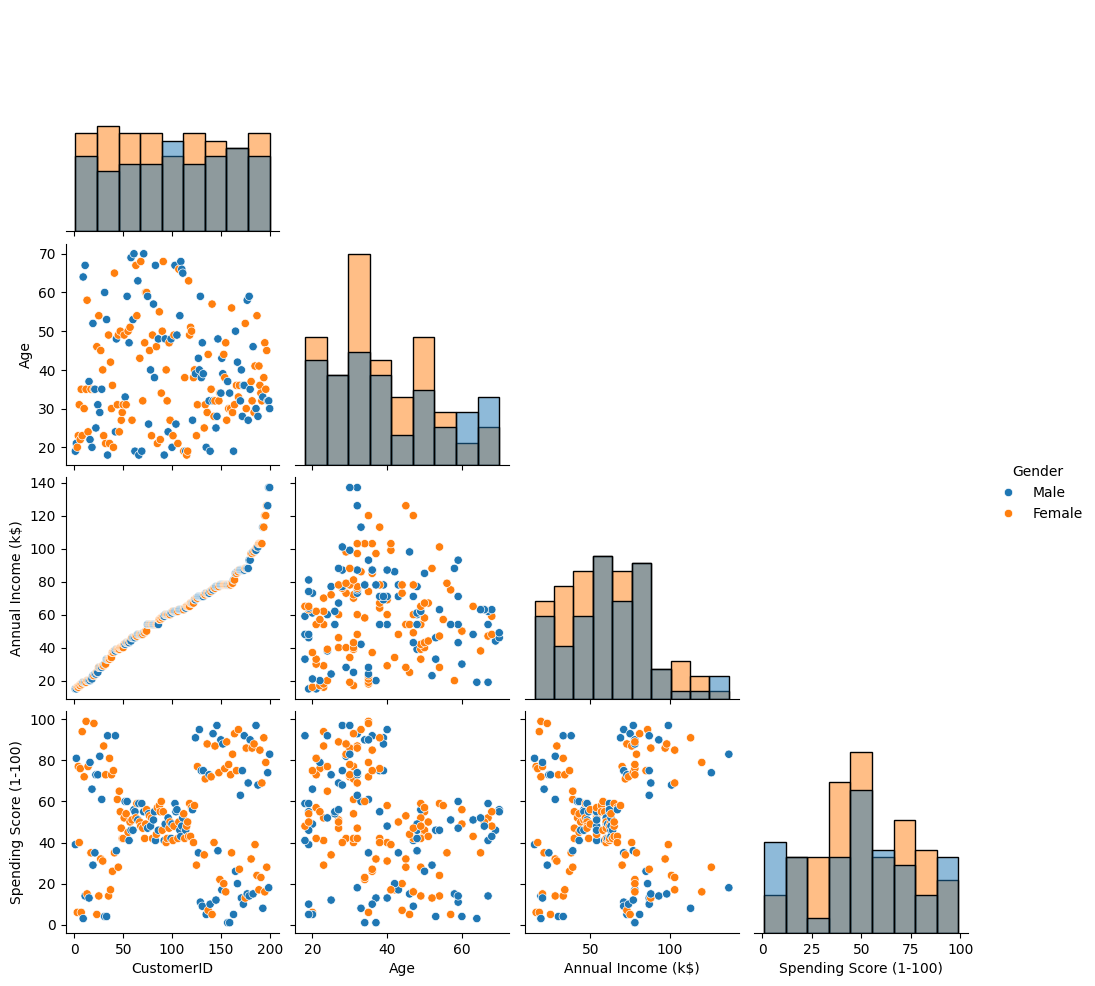

In [8]:
sns.pairplot(
    df,
    hue='Gender',
    diag_kind='hist',
    corner=True
)


# Preprocessing

In [9]:

df = df.drop(columns=['CustomerID'])

# Label encode Gender
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

df.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


<Axes: >

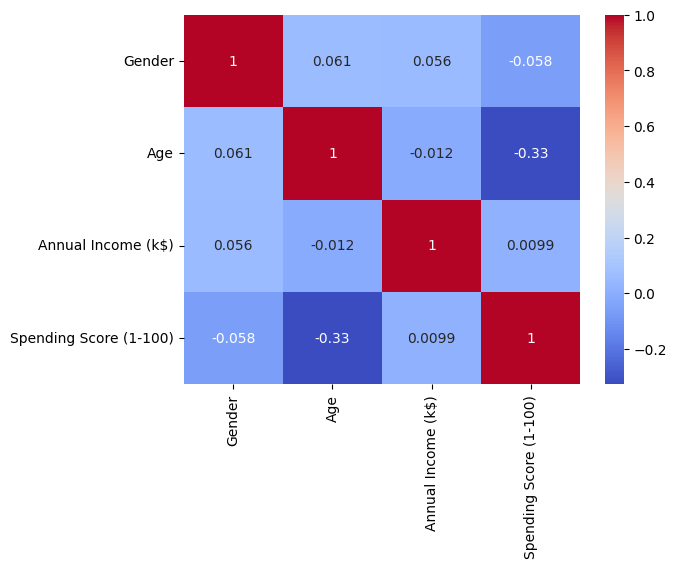

In [10]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [11]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Scale numeric features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Plot

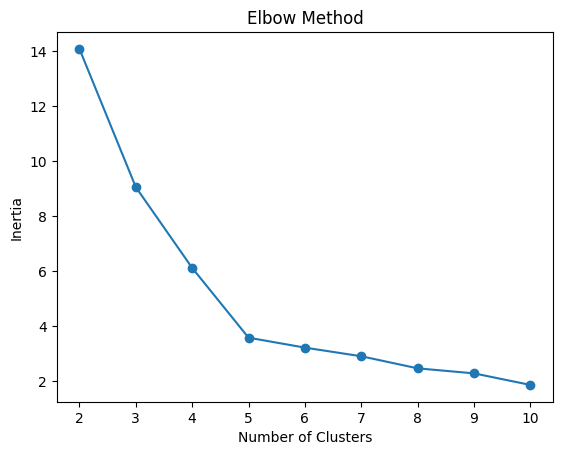

In [12]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# KMeans

In [13]:
model = KMeans(n_clusters=5, random_state=42)
y_predict = model.fit_predict(X_scaled)
df['clusters'] = y_predict

In [14]:
import plotly.express as px

from IPython.display import IFrame


fig = px.scatter(
    df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    color='clusters',
    title='Customer Segmentation using KMeans',
    size_max=60,
    hover_data=['Gender', 'Age']
)

# Save as HTML
fig.write_html("kmeans_clusters.html")

# Display the saved HTML in Kaggle Notebook
IFrame("kmeans_clusters.html", width=800, height=600)


In [15]:
segment_labels = {
    0: 'Careful',
    1: 'Standard',
    2: 'Target',
    3: 'Cautious Rich',
    4: 'Big Spenders'
}
df['Segment'] = df['clusters'].map(segment_labels)

# Plot using Plotly
fig = px.scatter(
    df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    color='Segment',
    symbol='Gender',  # optional: show Male/Female
    hover_data=['Age'],
    title='Customer Segmentation (Annual Income vs Spending Score)',
    width=800,
    height=600
)
fig.show()

# DBSCAN

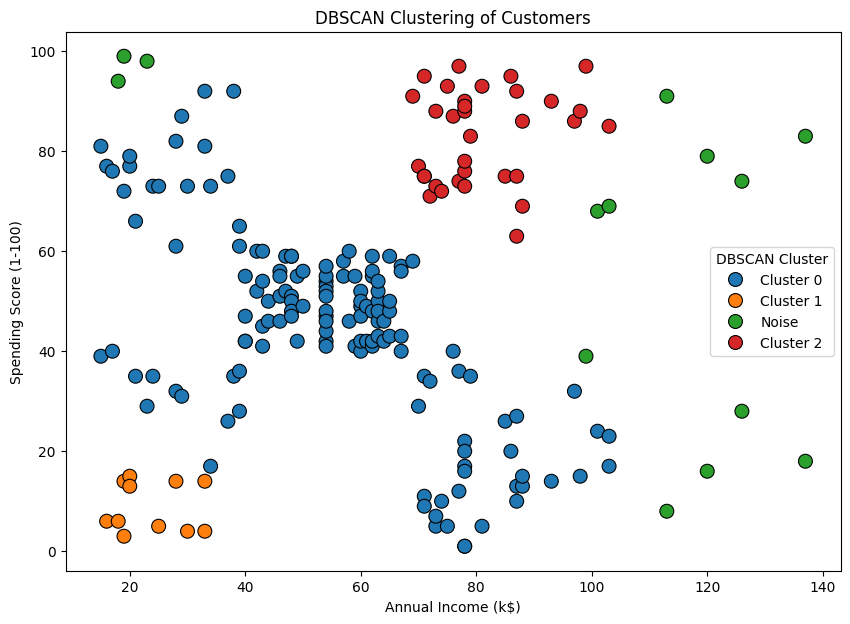

In [18]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)  # You may need to tune eps
dbscan_labels = dbscan.fit_predict(X_scaled)
df['DBSCAN'] = dbscan_labels

# Identify noise points
df['DBSCAN_label'] = df['DBSCAN'].apply(lambda x: 'Noise' if x == -1 else f'Cluster {x}')

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='DBSCAN_label',
    palette='tab10',
    data=df,
    s=100,
    edgecolor='k'
)
plt.title('DBSCAN Clustering of Customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='DBSCAN Cluster')
plt.show()

# Results

In [19]:
# Add labels to dataframe for visualization
df['KMeans'] = df["clusters"]
df['Agglomerative'] = df["Labels"]
df['DBSCAN'] = dbscan_labels

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print("DBSCAN clusters:", n_clusters)

# Silhouette score (only if more than 1 cluster)
if n_clusters > 1:
    score = silhouette_score(X_scaled, dbscan_labels)
    print("DBSCAN Silhouette Score:", score)
else:
    print("Silhouette score not defined for 1 cluster")


kmeans_silhouette = silhouette_score(X_scaled,df['KMeans'] )


agglo_silhouette = silhouette_score(X_scaled, df['Agglomerative'])

dbscan_silhouette=score



DBSCAN clusters: 3
DBSCAN Silhouette Score: 0.30856140710670954


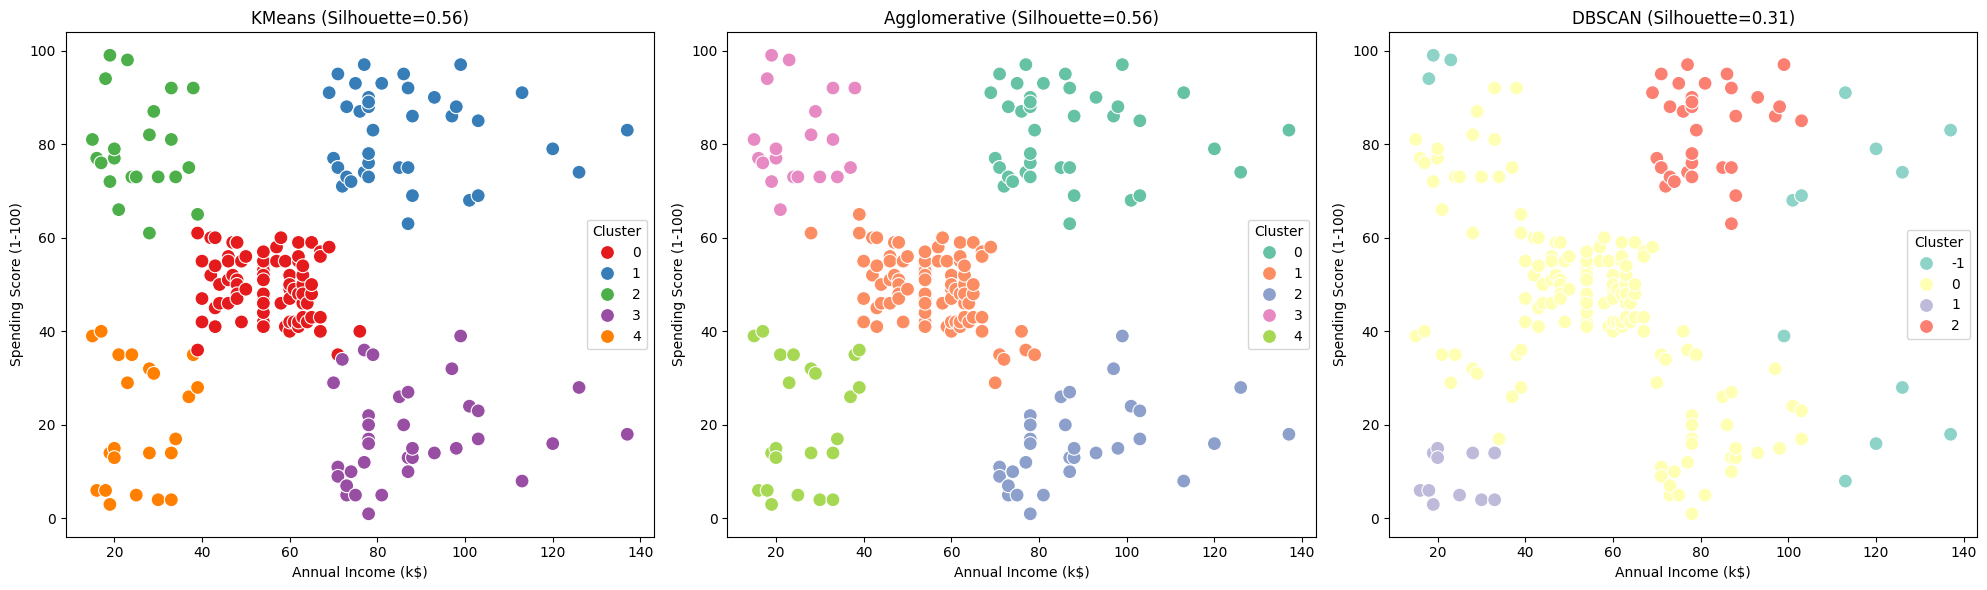

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='KMeans', palette='Set1', data=df, ax=axes[0], s=100
)
axes[0].set_title(f'KMeans (Silhouette={kmeans_silhouette:.2f})')

sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='Agglomerative', palette='Set2', data=df, ax=axes[1], s=100
)
axes[1].set_title(f'Agglomerative (Silhouette={agglo_silhouette:.2f})')

sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='DBSCAN', palette='Set3', data=df, ax=axes[2], s=100
)
axes[2].set_title(f'DBSCAN (Silhouette={dbscan_silhouette:.2f})')

for ax in axes:
    ax.set_xlabel('Annual Income (k$)')
    ax.set_ylabel('Spending Score (1-100)')
    ax.legend(title='Cluster')

plt.tight_layout()
plt.show()
